In [14]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

ACT_PATH  = "updated_activity_labels_2 (1).xlsx"
HORM_PATH = "hormones.xlsx"

Data Preprocessing

In [15]:
act = pd.read_excel(ACT_PATH)

act["date"] = pd.to_datetime(act["date"], errors="coerce")

# start = date + time_of_day
act["start"] = pd.to_datetime(
    act["date"].dt.strftime("%Y-%m-%d") + " " + act["time_of_day"].astype(str),
    errors="coerce"
)

act["minutes"] = pd.to_numeric(act["minutes"], errors="coerce")
act["end"] = act["start"] + pd.to_timedelta(act["minutes"], unit="m")

# CAT label from sampling_id (1 -> CAT01)
act["CAT"] = ("CAT" + act["sampling_id"].astype(str).str.zfill(2)).astype(str).str.strip()

# keep only usable rows
act = act.dropna(subset=["CAT", "start", "end", "activity_label"]).copy()
act["start"] = pd.to_datetime(act["start"], errors="coerce")
act["end"]   = pd.to_datetime(act["end"], errors="coerce")
act = act.dropna(subset=["start", "end"]).copy()
act=act.drop(columns=["sampling_id"])
act["activity_label"].value_counts(normalize=False)



activity_label
sit                  127
light_activity       102
stand                 51
lying                 25
moderate_activity     18
Name: count, dtype: int64

In [16]:
# =========================================================
# 2) Load HORMONES: read ALL sheets + concat
# =========================================================
sheets = pd.read_excel(HORM_PATH, sheet_name=None)

horm_list = []
for sheet_name, df in sheets.items():
    if not str(sheet_name).upper().startswith("CAT"):
        continue

    df = df.copy()
    # Drop any "Unnamed:*" columns immediately
    df = df.loc[:, ~df.columns.astype(str).str.startswith("Unnamed: 2")].copy()
    # Standardise first columns: assume first col is timestamp
    # and second col is CAT if present; otherwise fill with sheet name.
    if df.shape[1] < 1:
        continue
    # rename first column -> ts
    df = df.rename(columns={df.columns[0]: "ts"})
    # If there is a CAT column already, try to detect it; else use sheet_name

    df = df.rename(columns={df.columns[1]: "CAT"})
    df["CAT"]=sheet_name

    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
    df["CAT"] = df["CAT"].astype(str).str.strip()

    # If CAT is missing/blank in the sheet, fill from sheet name
    df.loc[df["CAT"].isin(["", "nan", "NaN"]), "CAT"] = sheet_name

    # drop rows with no timestamp
    df = df.dropna(subset=["ts"]).copy()

    horm_list.append(df)

horm = pd.concat(horm_list, ignore_index=True)

# Final nuke: remove any remaining Unnamed columns (just in case)
horm = horm.loc[:, ~horm.columns.astype(str).str.startswith("Unnamed")].copy()

print("CATs in act:", sorted(act["CAT"].unique()))
print("CATs in horm:", sorted(horm["CAT"].unique()))
print("Horm date range:", horm["ts"].min(), "to", horm["ts"].max())

CATs in act: ['CAT01', 'CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT06', 'CAT07', 'CAT09', 'CAT10', 'CAT11', 'CAT12', 'CAT13', 'CAT14', 'CAT15', 'CAT17', 'CAT18']
CATs in horm: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']
Horm date range: 2023-08-17 10:01:00 to 2024-02-22 12:26:00


In [17]:
# =========================================================
# 3) Keep only overlapping CATs
# =========================================================
cats_common = sorted(set(act["CAT"].unique()).intersection(set(horm["CAT"].unique())))
print("Common CATs:", cats_common)

act  = act[act["CAT"].isin(cats_common)].copy()
horm = horm[horm["CAT"].isin(cats_common)].copy()

print("CATs in act:", sorted(act["CAT"].unique()))
print("CATs in horm:", sorted(horm["CAT"].unique()))

Common CATs: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']
CATs in act: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']
CATs in horm: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']


In [18]:
# =========================================================
# 4) Align hormones -> activities (per CAT, robust)
# =========================================================
out = []

for cat, hcat in horm.groupby("CAT", sort=False):
    acat = act[act["CAT"] == cat].copy()
    if len(acat) == 0 or len(hcat) == 0:
        continue

    acat = acat.sort_values("start").reset_index(drop=True)
    hcat = hcat.sort_values("ts").reset_index(drop=True)

    # Drop CAT so merge doesn't create CAT_x/CAT_y
    acat = acat.drop(columns=["CAT"], errors="ignore")
    hcat = hcat.drop(columns=["CAT"], errors="ignore")

    m = pd.merge_asof(
        hcat,
        acat,
        left_on="ts",
        right_on="start",
        direction="backward",
        allow_exact_matches=True
    )

    # keep only if ts is inside [start, end)
    m = m[m["ts"] < m["end"]].copy()
    m["CAT"] = cat

    out.append(m)

merged = pd.concat(out, ignore_index=True) if out else pd.DataFrame()
print("Aligned rows:", len(merged))
print("Aligned CATs:", sorted(merged["CAT"].unique()) if len(merged) else [])

# Drop any leftover Unnamed columns
merged = merged.loc[:, ~merged.columns.astype(str).str.startswith("Unnamed")].copy() 

Aligned rows: 102
Aligned CATs: ['CAT03', 'CAT04', 'CAT05', 'CAT11']


In [19]:
# =========================================================
# 5) Time features
# =========================================================
merged["hour"] = merged["ts"].dt.hour
merged["minute"] = merged["ts"].dt.minute
merged["tod_min"] = merged["hour"] * 60 + merged["minute"]
merged["tod_sin"] = np.sin(2 * np.pi * merged["tod_min"] / 1440.0)
merged["tod_cos"] = np.cos(2 * np.pi * merged["tod_min"] / 1440.0)

In [20]:
merged.columns = (
    merged.columns
        .astype(str)
        .str.strip()
        .str.lower()
)

In [21]:
# =========================================================
# 6) Fix rare classes (so stratify works)
# =========================================================
target = "activity_label"
min_count = 2  # minimum for stratify; set 5 for more stable learning

vc = merged[target].value_counts() #this creates dictionary
rare = vc[vc < min_count].index #index extracts their name of the rare
merged = merged[~merged[target].isin(rare)].copy()  #takes out the non rare ones
# merged[target]=merged[target].replace("light_activity","stand")
print("Class counts:\n", merged[target].value_counts())
print(merged.columns.values.tolist()) 

Class counts:
 activity_label
sit               51
stand             24
light_activity    15
lying             11
Name: count, dtype: int64
['ts', 'metanephrine', 'normetanephrine', '3-mt', 'noradrenaline', 'adrenaline', 'dopamine', 'ldopa', '3-omd', 'dopac', 'dopeg', 'melatonin', '18-oh-cortisol', 'cortisol', 'cortisone', 'dopeg', 'cortisol', 'cortisone', 'date', 'activity_number', 'description', 'intensity', 'minutes', 'time_of_day', 'activity_label', 'start', 'end', 'cat', 'hour', 'minute', 'tod_min', 'tod_sin', 'tod_cos']


In [22]:
def collapse_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip().str.lower()

    new_cols = {}
    for name in pd.unique(df.columns):
        block = df.loc[:, df.columns == name]
        if block.shape[1] == 1:
            new_cols[name] = block.iloc[:, 0]
        else:
            new_cols[name] = block.bfill(axis=1).iloc[:, 0]  # coalesce duplicates

    return pd.DataFrame(new_cols, index=df.index)

merged = collapse_duplicate_columns(merged)

In [ ]:
# =========================================================
# 7) Build X / y
# =========================================================
exclude = {
    "ts","date","time_of_day","start","end",
    "minutes","description","intensity","activity_number","hour" ,'minute', 'tod_min', 'tod_sin', 'tod_cos',
    "cat",
    target
}

feature_cols = [c for c in merged.columns if c not in exclude]

X = merged[feature_cols].copy()
print(X.columns.values.tolist())
y = merged[target].copy()



# Drop fully empty cols
X = X.dropna(axis=1, how="all")
# =========================================================
# 8) Train + Evaluate XGBoost with Stratified K-Fold CV
# =========================================================


le = LabelEncoder()
y_enc = le.fit_transform(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, bal_accs, macro_f1s = [], [], []

# store out-of-fold predictions (one prediction for every sample, made by a model that didn't train on it)
oof_pred = np.full_like(y_enc, fill_value=-1)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_enc), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]

    model = XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
    )
#     model = RandomForestClassifier(
#     n_estimators=500,
#     max_depth=5,
#     min_samples_leaf=2,
#     class_weight="balanced",
#     random_state=42
# )

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # fold metrics
    accs.append(accuracy_score(y_test, pred))
    bal_accs.append(balanced_accuracy_score(y_test, pred))
    macro_f1s.append(f1_score(y_test, pred, average="macro"))

    oof_pred[test_idx] = pred

print("Classes:", list(le.classes_))
print(f"Accuracy:          {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Balanced accuracy: {np.mean(bal_accs):.3f} ± {np.std(bal_accs):.3f}")
print(f"Macro F1:          {np.mean(macro_f1s):.3f} ± {np.std(macro_f1s):.3f}")

# overall report using out-of-fold predictions (most honest single report you can give)
print("\nOut-of-fold classification report:")
print(classification_report(y_enc, oof_pred, target_names=le.classes_))


['metanephrine', 'normetanephrine', '3-mt', 'noradrenaline', 'adrenaline', 'dopamine', 'ldopa', '3-omd', 'dopac', 'dopeg', 'melatonin', '18-oh-cortisol', 'cortisol', 'cortisone']
Classes: ['light_activity', 'lying', 'sit', 'stand']
Accuracy:          0.682 ± 0.071
Balanced accuracy: 0.562 ± 0.070
Macro F1:          0.562 ± 0.100

Out-of-fold classification report:
                precision    recall  f1-score   support

light_activity       0.44      0.27      0.33        15
         lying       0.36      0.36      0.36        11
           sit       0.69      0.78      0.73        51
         stand       0.91      0.88      0.89        24

      accuracy                           0.68       101
     macro avg       0.60      0.57      0.58       101
  weighted avg       0.67      0.68      0.67       101



['metanephrine', 'normetanephrine', '3-mt', 'noradrenaline', 'adrenaline', 'dopamine', 'ldopa', '3-omd', 'dopac', 'dopeg', 'melatonin', '18-oh-cortisol', 'cortisol', 'cortisone']


<Axes: >

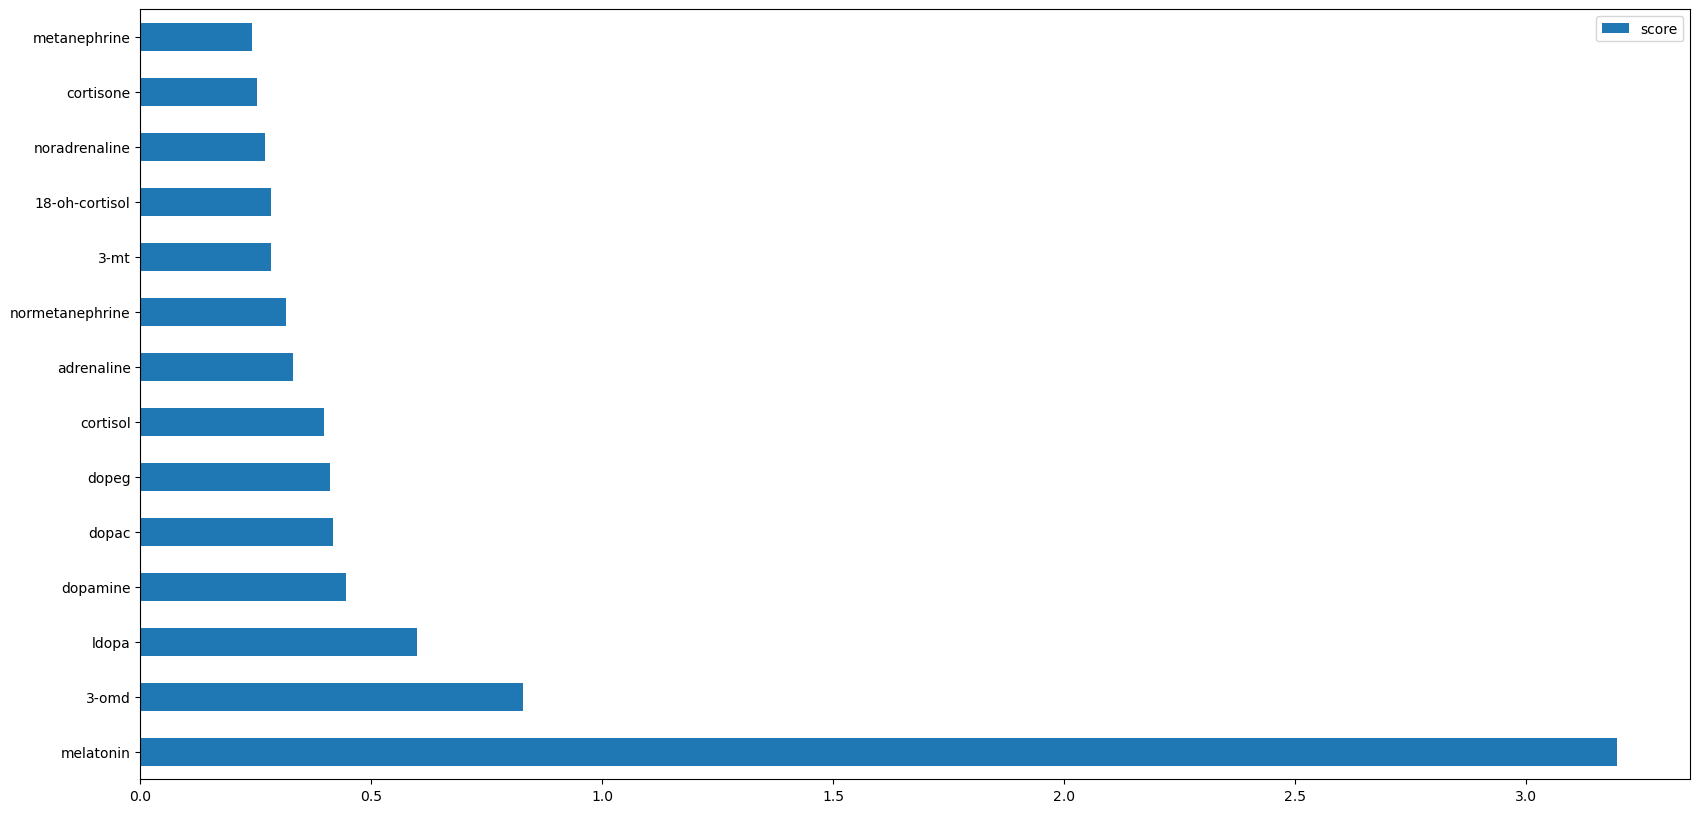

In [25]:
# Source - https://stackoverflow.com/a/52777909
# Posted by Chau Pham, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-30, License - CC BY-SA 4.0

if model is XGBClassifier:
    feature_important = model.get_booster().get_score(importance_type='gain')
elif model is RandomForestClassifier:
    feature_important=model.feature_importances_
keys = list(feature_important.keys())
print(keys)
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
